## Imports

In [84]:
#imports
import pandas as pd
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import to_categorical


#more imports
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn import linear_model, svm
from sklearn.model_selection import cross_val_score,KFold
from sklearn.pipeline import FeatureUnion, Pipeline, make_union, make_pipeline
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, cross_val_score
from sklearn.neural_network import MLPRegressor

from sklearn.decomposition import PCA

## Create Dataframe

In [3]:
#define the URL
left_side ='https://api.data.gov/ed/collegescorecard/v1/schools?school.degrees_awarded.predominant=3&fields=school.name,id,2013.completion.rate_suppressed.lt_four_year_150percent,2013.student.retention_rate.four_year.full_time,school.ft_faculty_rate,school.tuition_revenue_per_fte,school.instructional_expenditure_per_fte,school.men_only,school.women_only,school.minority_serving.historically_black,school.minority_serving.predominantly_black,2013.academics.program_percentage.engineering,2013.academics.program_percentage.humanities,2013.academics.program_percentage.physical_science,2013.academics.program_percentage.social_science,2013.academics.program_percentage.biological,2013.admissions.admission_rate.overall,2013.admissions.sat_scores.average.overall,2013.cost.attendance.academic_year,2013.student.share_first.time_full.time,2013.student.share_lowincome.0_30000,2013.student.share_middleincome.30001_48000,2013.student.share_middleincome.48001_75000,2013.student.share_highincome.75001_110000,2013.student.share_highincome.110001plus,2013.student.share_firstgeneration,2013.student.share_firstgeneration_parents.somecollege,2013.student.share_firstgeneration_parents.highschool,2013.student.share_firstgeneration_parents.middleschool,2013.aid.federal_loan_rate,2013.aid.median_debt.completers.overall,2013.earnings.10_yrs_after_entry.working_not_enrolled.mean_earnings&sort=school.name&per_page=100&page='
right_side = '&api_key=iWpmbz9Bzlap6R3TCn5prVHlLXnIgeQC7xArrHQu'

In [ ]:
#Write a function to construct a dataframe
dict1 = {}
df2 = pd.DataFrame(dict1)
list1 = []
for i in range(1, 31):
    list1.append(left_side+ str(i)+right_side)
    for url in list1:
        api = requests.get(url)
        api_dict= json.loads(api.content)
        df = pd.DataFrame(api_dict['results'])
        df2 = pd.concat([df2, df], axis=0)

In [ ]:
df2.head(3)

In [ ]:
#save to csv so we don't lose dataframe...
df2.to_csv('college_earnings.csv')

In [102]:
df2 = pd.read_csv('college_earnings.csv')

## EDA

In [86]:
#Checkout null values
df2.isnull().sum()

Unnamed: 0                                                                 0
2013.academics.program_percentage.biological                             752
2013.academics.program_percentage.engineering                            752
2013.academics.program_percentage.humanities                             752
2013.academics.program_percentage.physical_science                       752
2013.academics.program_percentage.social_science                         752
2013.admissions.admission_rate.overall                                  8130
2013.admissions.sat_scores.average.overall                             14286
2013.aid.federal_loan_rate                                               850
2013.aid.median_debt.completers.overall                                 3898
2013.completion.rate_suppressed.lt_four_year_150percent                41090
2013.cost.attendance.academic_year                                      3398
2013.earnings.10_yrs_after_entry.working_not_enrolled.mean_earnings     4519

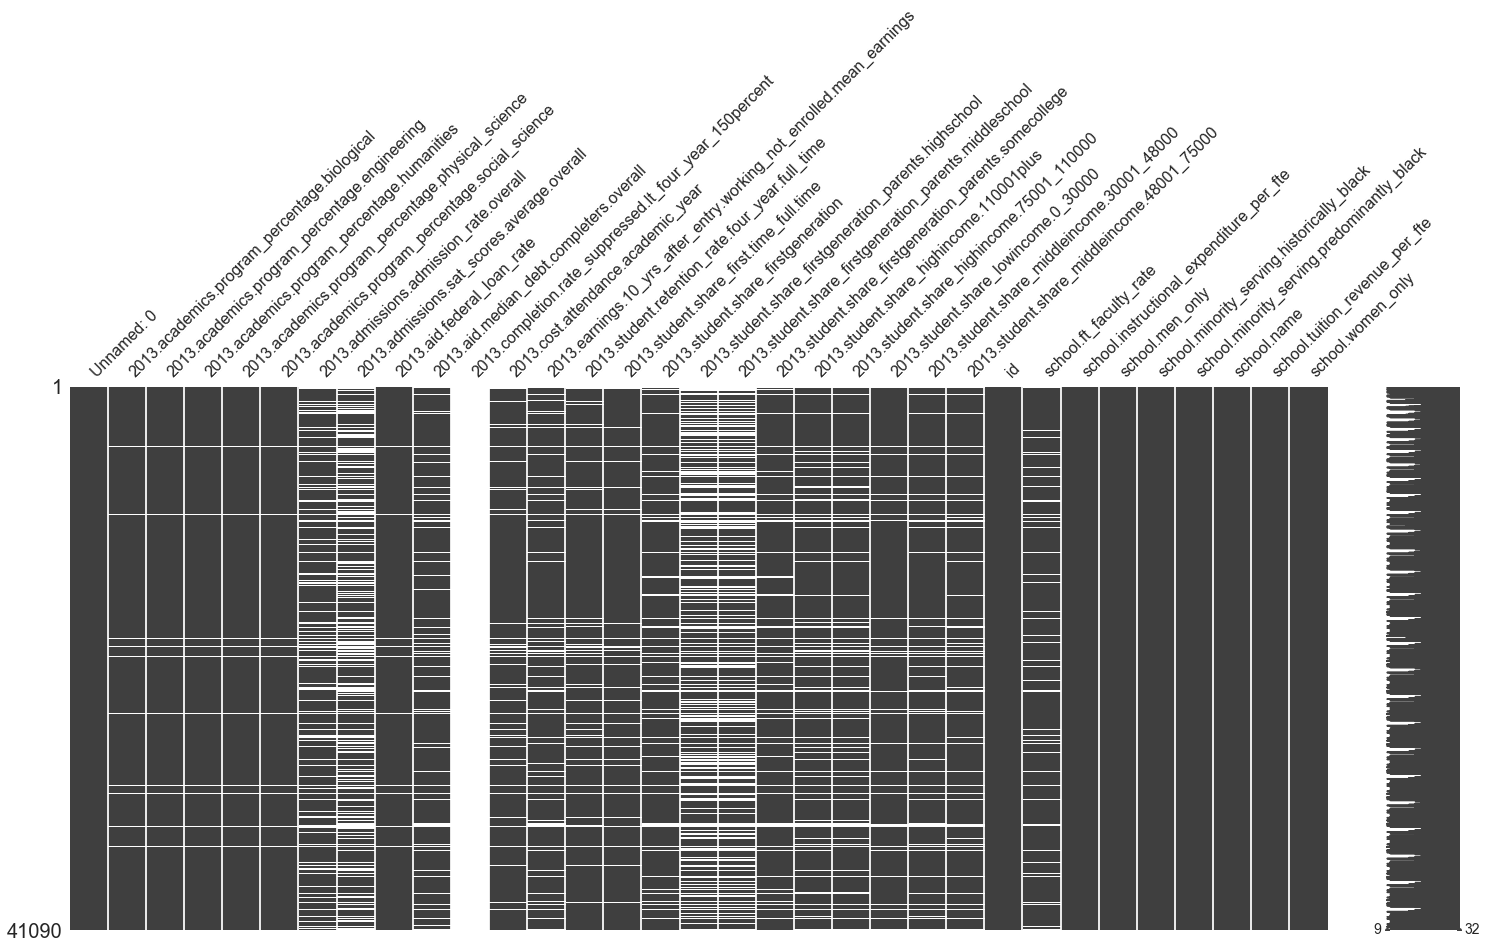

In [103]:
import missingno as msno
%matplotlib inline
msno.matrix(df2)

In [87]:
#Drop duplicates
df3=df2.drop_duplicates()

In [88]:
#Set index to school name
df3= df3.set_index('school.name')

In [89]:
#Highest earning graduates are from these schools 
df3['2013.earnings.10_yrs_after_entry.working_not_enrolled.mean_earnings'].sort_values(ascending = False).head(15)


school.name
Louisiana State University Health Sciences Center-Shreveport    167300.0
Rosalind Franklin University of Medicine and Science            164600.0
SUNY Downstate Medical Center                                   160900.0
Massachusetts Institute of Technology                           142100.0
Harvard University                                              136700.0
The University of Texas Health Science Center at Houston        128400.0
University of Pennsylvania                                      123600.0
Stanford University                                             122900.0
Thomas Jefferson University                                     122900.0
Georgetown University                                           118900.0
Yale University                                                 118400.0
Upstate Medical University                                      117900.0
Rush University                                                 116100.0
Princeton University                   

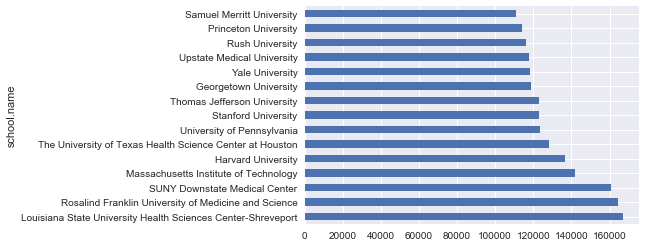

In [99]:
df3['2013.earnings.10_yrs_after_entry.working_not_enrolled.mean_earnings'].sort_values(ascending=False).head(15).plot(kind='barh');

In [10]:
#mean earnings
df3['2013.earnings.10_yrs_after_entry.working_not_enrolled.mean_earnings'].mean()

48013.96522714526

In [11]:
#Rename columns
df3=df3.rename(columns={
    '2013.aid.median_debt.completers.overall': 'median_debt',
    '2013.earnings.10_yrs_after_entry.working_not_enrolled.mean_earnings':'earnings_10yrs.mean',
    '2013.repayment.1_yr_repayment.completers': 'loanrepayersin1yr',
    '2013.academics.program_percentage.biological': '%students_biological',
    '2013.academics.program_percentage.engineering': '%students_engineering',
    '2013.academics.program_percentage.humanities': '%students_humanities',
    '2013.academics.program_percentage.physical_science': '%students_physical_science',
    '2013.academics.program_percentage.social_science': '%students_social_science',
    '2013.admissions.admission_rate.overall':'admission_rate',
    '2013.admissions.sat_scores.average.overall':'sat_avg',
    '2013.aid.federal_loan_rate':'%students_w/fedloans',
    '2013.cost.attendance.academic_year':'attendance_cost_per_year',
    '2013.student.retention_rate.four_year.full_time':'student_retention_rate',
    '2013.student.share_first.time_full.time':'share_first_time_students'})

In [12]:
df3.head(3)

,Unnamed: 0,%students_biological,%students_engineering,%students_humanities,%students_physical_science,%students_social_science,admission_rate,sat_avg,%students_w/fedloans,median_debt,...,2013.student.share_middleincome.30001_48000,2013.student.share_middleincome.48001_75000,id,school.ft_faculty_rate,school.instructional_expenditure_per_fte,school.men_only,school.minority_serving.historically_black,school.minority_serving.predominantly_black,school.tuition_revenue_per_fte,school.women_only
school.name,,,,,,,,,,,,,,,,,,,,,
Aspen University,0,0.0000,0.0,0.0789,0.0000,0.0000,NaN,NaN,0.0831,NaN,...,0.083969,0.122137,454829,0.0000,1052,0,0,0,4949,0
Assumption College,1,0.0811,0.0,0.0142,0.0101,0.1339,0.7422,NaN,0.7146,27000.0,...,0.093023,0.158140,164562,0.5189,8185,0,0,0,14674,0
Athens State University,2,0.0243,0.0,0.0540,0.0011,0.0221,NaN,NaN,0.6277,18061.0,...,0.198623,0.152542,100812,0.4450,6741,0,0,0,6189,0


In [13]:
df3=df3.drop('2013.completion.rate_suppressed.lt_four_year_150percent', axis=1)

In [14]:
df3.shape

(2009, 31)

In [15]:
df3.isnull().sum()

Unnamed: 0                                                   0
%students_biological                                        42
%students_engineering                                       42
%students_humanities                                        42
%students_physical_science                                  42
%students_social_science                                    42
admission_rate                                             415
sat_avg                                                    704
%students_w/fedloans                                        47
median_debt                                                197
attendance_cost_per_year                                   167
earnings_10yrs.mean                                        226
student_retention_rate                                     168
share_first_time_students                                  131
2013.student.share_firstgeneration                         218
2013.student.share_firstgeneration_parents.highschool  

In [16]:
df3=df3.dropna()

In [17]:
df3.shape

(945, 31)

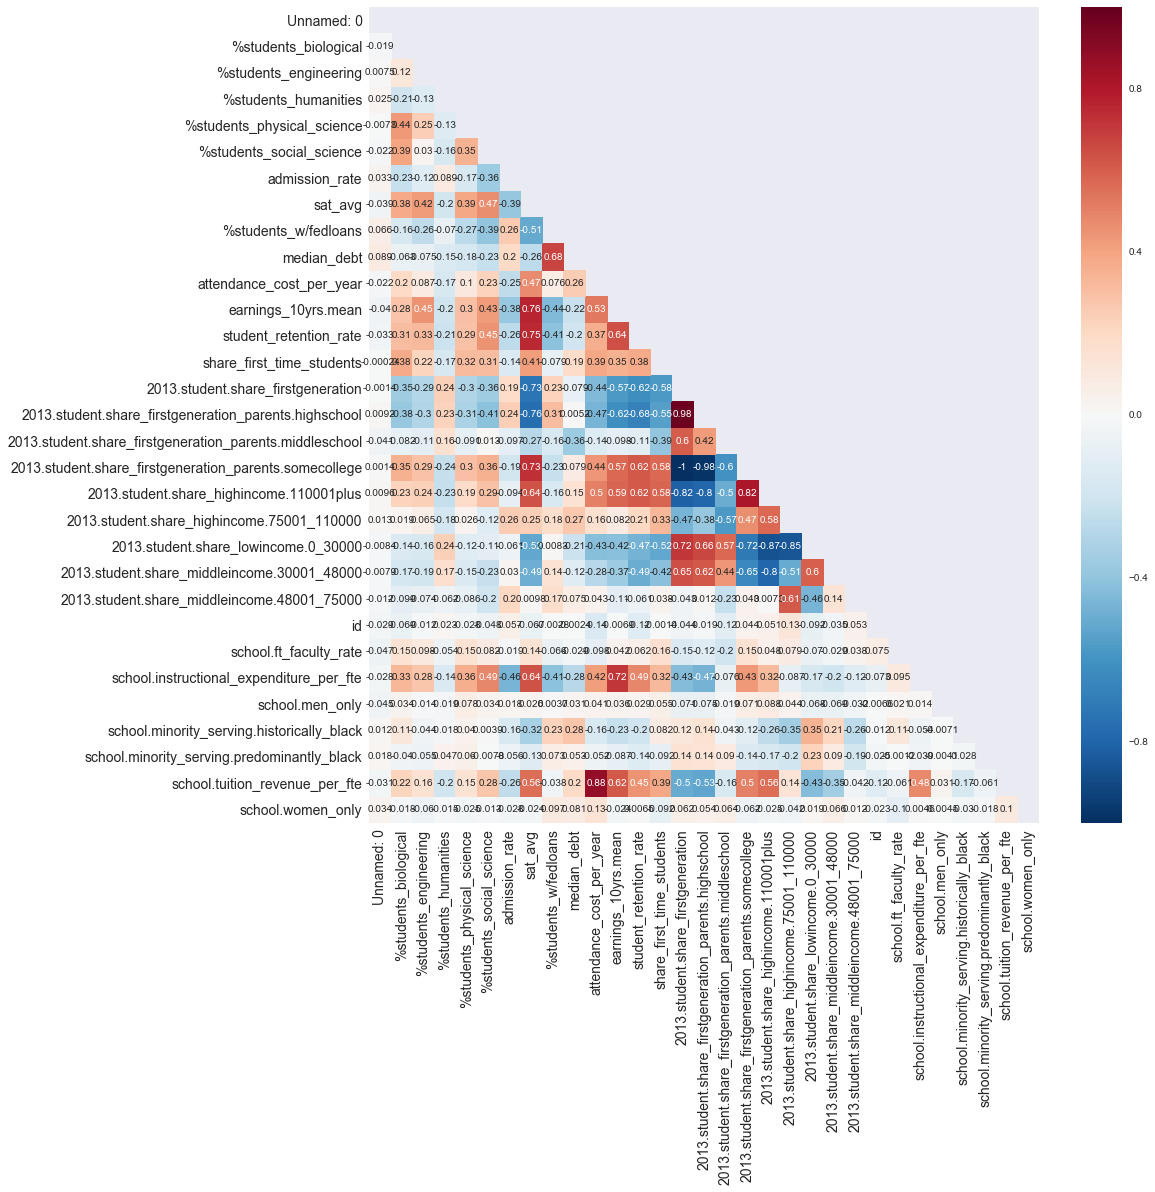

In [18]:
#Correlation matrix/heatmap

df3_corr = df3.corr()
fix, ax = plt.subplots(figsize=(15,15))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df3_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(df3_corr, mask=mask, ax=ax, annot=True)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
plt.show()

In [19]:
df3.columns

Index(['Unnamed: 0', '%students_biological', '%students_engineering',
       '%students_humanities', '%students_physical_science',
       '%students_social_science', 'admission_rate', 'sat_avg',
       '%students_w/fedloans', 'median_debt', 'attendance_cost_per_year',
       'earnings_10yrs.mean', 'student_retention_rate',
       'share_first_time_students', '2013.student.share_firstgeneration',
       '2013.student.share_firstgeneration_parents.highschool',
       '2013.student.share_firstgeneration_parents.middleschool',
       '2013.student.share_firstgeneration_parents.somecollege',
       '2013.student.share_highincome.110001plus',
       '2013.student.share_highincome.75001_110000',
       '2013.student.share_lowincome.0_30000',
       '2013.student.share_middleincome.30001_48000',
       '2013.student.share_middleincome.48001_75000', 'id',
       'school.ft_faculty_rate', 'school.instructional_expenditure_per_fte',
       'school.men_only', 'school.minority_serving.historically_

In [20]:
features =['%students_biological', '%students_engineering', '%students_humanities',
       '%students_physical_science', '%students_social_science',
       'admission_rate', 'sat_avg', '%students_w/fedloans', 'median_debt',
       'attendance_cost_per_year','student_retention_rate', 'share_first_time_students',
       '2013.student.share_firstgeneration',
       '2013.student.share_firstgeneration_parents.highschool',
       '2013.student.share_firstgeneration_parents.middleschool',
       '2013.student.share_firstgeneration_parents.somecollege',
       '2013.student.share_highincome.110001plus',
       '2013.student.share_highincome.75001_110000',
       '2013.student.share_lowincome.0_30000',
       '2013.student.share_middleincome.30001_48000',
       '2013.student.share_middleincome.48001_75000', 'id',
       'school.ft_faculty_rate', 'school.instructional_expenditure_per_fte',
       'school.men_only', 'school.minority_serving.historically_black',
       'school.minority_serving.predominantly_black',
       'school.tuition_revenue_per_fte', 'school.women_only']

In [21]:

df3[df3['earnings_10yrs.mean']>80000]

,Unnamed: 0,%students_biological,%students_engineering,%students_humanities,%students_physical_science,%students_social_science,admission_rate,sat_avg,%students_w/fedloans,median_debt,...,2013.student.share_middleincome.30001_48000,2013.student.share_middleincome.48001_75000,id,school.ft_faculty_rate,school.instructional_expenditure_per_fte,school.men_only,school.minority_serving.historically_black,school.minority_serving.predominantly_black,school.tuition_revenue_per_fte,school.women_only
school.name,,,,,,,,,,,,,,,,,,,,,
Bentley University,59,0.0000,0.0000,0.0009,0.0000,0.0000,0.4379,1234.0,0.5074,27000.0,...,0.105303,0.140909,164739,0.6501,13948,0,0,0,27181,0
Boston College,1,0.0862,0.0000,0.0000,0.0177,0.1708,0.3222,1375.0,0.4131,19000.0,...,0.095403,0.133131,164924,0.5787,22248,0,0,0,31361,0
Brown University,21,0.1094,0.0644,0.0000,0.0393,0.2246,0.0918,1425.0,0.2317,16000.0,...,0.119826,0.173566,217156,0.8770,32871,0,0,0,33356,0
California State University Maritime Academy,45,0.0000,0.1149,0.0000,0.0000,0.1609,0.7480,1080.0,0.6043,26000.0,...,0.123711,0.082474,111188,0.7500,18783,0,0,0,9465,0
Carnegie Mellon University,81,0.0385,0.2464,0.0262,0.0712,0.0538,0.2549,1432.0,0.3964,25998.0,...,0.110439,0.142965,211440,0.9408,32159,0,0,0,37280,0
Case Western Reserve University,88,0.1292,0.3018,0.0011,0.0601,0.0746,0.4188,1377.0,0.4815,24500.0,...,0.129734,0.159187,201645,0.7906,30814,0,0,0,23564,0
Columbia University in the City of New York,99,0.0764,0.1645,0.0052,0.0391,0.2414,0.0742,1471.0,0.2659,19250.0,...,0.131296,0.123452,190150,0.5289,77711,0,0,0,31658,0
Cornell University,20,0.1300,0.1699,0.0028,0.0263,0.1045,0.1556,1422.0,0.3154,11750.0,...,0.115649,0.122536,190415,0.9052,24604,0,0,0,26069,0
Dartmouth College,52,0.1011,0.0879,0.0000,0.0302,0.3535,0.0978,1446.0,0.2454,11957.0,...,0.105740,0.131923,182670,0.8249,26574,0,0,0,30410,0


## Models

In [22]:
#Define Variables
X = df3[features]
y= df3[ 'earnings_10yrs.mean']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 

49571.066625
-568.1130384619418
0.679657697097
{'gbr__learning_rate': 0.1, 'gbr__max_depth': 5, 'gbr__max_features': 'log2', 'gbr__max_leaf_nodes': None, 'gbr__n_estimators': 50}


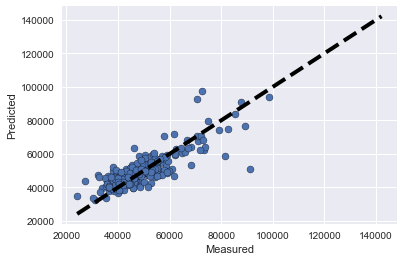

In [24]:
#Model 1: GradientBoosting Regressor w/Gridsearch
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=10))
gbr = ('gbr',GradientBoostingRegressor())
pipe=Pipeline([scaling, pca, gbr])

param_grid = dict(gbr__n_estimators=[5,10,20,50,75,100,125],
              gbr__max_depth=[2,3,4,5],
              gbr__max_features=['auto', 'log2', None],
              gbr__max_leaf_nodes=[2,3,None],
              gbr__learning_rate=[0.1,0.3,0.5])
grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train,y_train)
preds = grid_search.predict(X_test)
residual = y_test-preds
print (preds.mean())
print(residual.mean())
print (grid_search.score(X_test, y_test))
print(grid_search.best_params_)

fig, ax = plt.subplots()
ax.scatter(y_test, preds, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

50184.5492824
-1181.5956958640204
0.674149067068


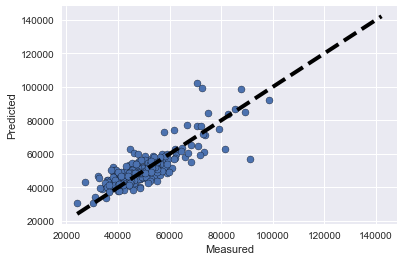

In [25]:
#Model 2: GradientBoosting Regressor w/Gridsearched parameters & AdaBoostRegressor
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=10))
gbr = ('gbr',AdaBoostRegressor(GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features=None, max_leaf_nodes=None, n_estimators=75)))
pipe=Pipeline([scaling, pca, gbr])

pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)
residual = y_test-preds
print (preds.mean())
print(residual.mean())
print (pipe.score(X_test, y_test))

fig, ax = plt.subplots()
ax.scatter(y_test, preds, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

49755.1392405
-752.1856540084389
0.682664383301
{'rfr__max_features': 'log2', 'rfr__n_estimators': 50}


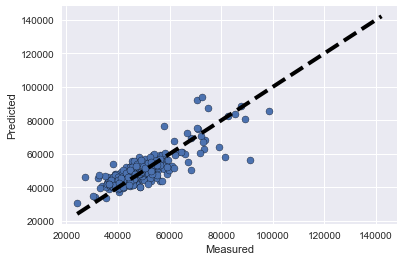

In [36]:
#Model 3: RandomForest Regressor w/Gridsearch:
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=10))
rfr = ('rfr',RandomForestRegressor())
pipe=Pipeline([scaling, pca, rfr])
param_grid = dict(rfr__n_estimators=[5,10,20,50,75],
              rfr__max_features=['auto','sqrt', 'log2'])
grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train,y_train)
preds = grid_search.predict(X_test)
residual = y_test-preds
print (preds.mean())
print(residual.mean())
print (grid_search.score(X_test, y_test))
print(grid_search.best_params_)

fig, ax = plt.subplots()
ax.scatter(y_test, preds, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [79]:
df5=pd.DataFrame(data={'Predictions': preds, 'Actual': y_test})
df5.head(3)

,Actual,Predictions
school.name,,
Queens University of Charlotte,44100.0,50938.0
East Texas Baptist University,42100.0,41730.0
Pacific Lutheran University,52300.0,50024.0


In [81]:
df5.to_csv('earningspredictions.csv')

49822.1265823
-819.1729957805907
0.664005481008


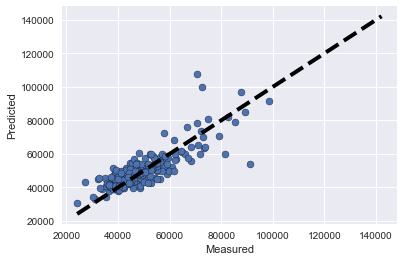

In [27]:
#Model 3: RandomForest Regressor w/Gridsearched parameters and AdaBoost:

scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=10))
gbr = ('rfr',AdaBoostRegressor(RandomForestRegressor(max_features='auto', n_estimators= 75)))
pipe=Pipeline([scaling, pca, gbr])
pipe.fit(X_train,y_train)
preds = pipe.predict(X_test)
residual = y_test-preds
print (preds.mean())
print(residual.mean())
print (pipe.score(X_test, y_test))

fig, ax = plt.subplots()
ax.scatter(y_test, preds, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

49531.1281699
-528.1745834364909
0.543402222302
{'rfr__max_depth': 5, 'rfr__max_features': 7}


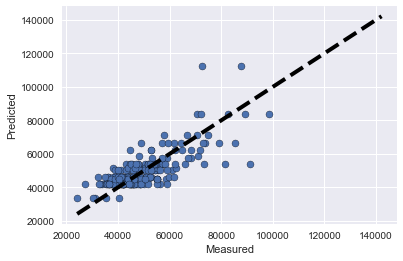

In [28]:
#Model 4 Decision Tree Regressor w/Gridsearch:
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=10))
gbr = ('rfr',(DecisionTreeRegressor()))
pipe=Pipeline([scaling, pca, gbr])

param_grid = dict(rfr__max_depth=[5,10,20,50,75],
              rfr__max_features=[3,4,5,6,7])
grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train,y_train)
preds = grid_search.predict(X_test)
residual = y_test-preds
print (preds.mean())
print(residual.mean())
print (grid_search.score(X_test, y_test))
print(grid_search.best_params_)


fig, ax = plt.subplots()
ax.scatter(y_test, preds, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

49170.8860759
-167.93248945147678
0.67841275525


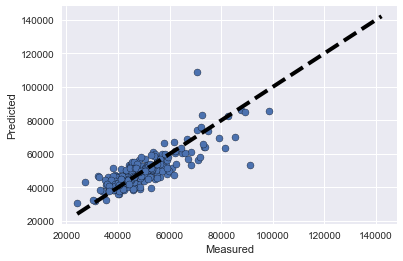

In [29]:
#Model 5 Decision Tree Regressor w/AdaBoost
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=10))
gbr = ('rfr',AdaBoostRegressor(DecisionTreeRegressor()))
pipe=Pipeline([scaling, pca, gbr])

pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)
residual = y_test-preds
print (preds.mean())
print(residual.mean())
print (pipe.score(X_test, y_test))


fig, ax = plt.subplots()
ax.scatter(y_test, preds, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

52544.414185
-3541.4605985456983
0.518079813607


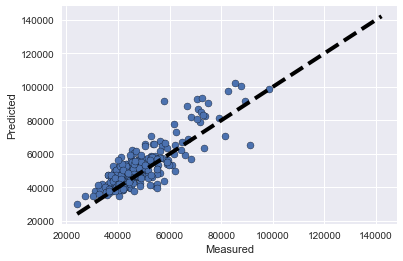

In [30]:
#Model 6 LassoCV with AdaBoost
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=10))
gbr = ('rfr',AdaBoostRegressor(LassoCV()))
pipe=Pipeline([scaling, pca, gbr])

pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)
residual = y_test-preds
print (preds.mean())
print(residual.mean())
print (pipe.score(X_test, y_test))


fig, ax = plt.subplots()
ax.scatter(y_test, preds, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

51120.1870438
-2117.233457300479
0.614705096359


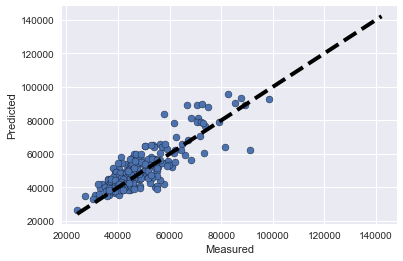

In [31]:
#Model 7 RidgeCV with AdaBoost
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=10))
gbr = ('rfr',AdaBoostRegressor(RidgeCV()))
pipe=Pipeline([scaling, pca, gbr])

pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)
residual = y_test-preds
print (preds.mean())
print(residual.mean())
print (pipe.score(X_test, y_test))


fig, ax = plt.subplots()
ax.scatter(y_test, preds, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [32]:
X_train.shape

(708, 29)

## PCA Components

In [33]:
df4=pd.DataFrame(pipe.named_steps['pca'].components_.T, columns=['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'],index = features)

In [101]:
df4.shape

(29, 10)

In [34]:
#The features that had the most predictive value were "2013.student.share_firstgeneration" and "2013.student.share_firstgeneration_parents.somecollege"suggesting
#whether or not parents went to some college was the greatest determinant of future income.
#(Based on the greatest percentage in PC1)
df4

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
%students_biological,0.136589,0.167539,0.151860,-0.197965,-0.283565,0.300870,0.060185,0.000023,-0.181967,-0.197137
%students_engineering,0.132553,0.134965,-0.089949,-0.070699,-0.045660,-0.304118,-0.168725,-0.255201,-0.083983,0.603039
%students_humanities,-0.101209,0.049188,-0.144200,0.064150,0.251959,-0.143733,0.075797,-0.029618,0.498268,-0.399345
%students_physical_science,0.122959,0.181493,0.016249,-0.215884,-0.225750,0.408799,-0.166967,0.041924,-0.040696,-0.038785
%students_social_science,0.152080,0.279080,0.065053,-0.038707,-0.035055,0.170478,0.153387,0.156742,-0.088357,-0.231254
admission_rate,-0.091120,-0.286245,-0.183687,-0.042283,0.105184,0.237251,-0.016134,-0.180933,-0.124369,0.020740
sat_avg,0.287116,0.149096,-0.135488,0.090498,-0.058252,-0.067658,-0.095707,-0.007891,0.055150,0.050878
%students_w/fedloans,-0.099031,-0.325600,0.384943,0.002763,-0.073901,0.019435,-0.068900,-0.002380,0.002373,0.000133
median_debt,0.007332,-0.322565,0.458647,-0.059118,0.040344,-0.042581,-0.052961,-0.049977,-0.024004,0.065304
attendance_cost_per_year,0.199823,-0.026280,0.297049,0.388443,-0.067725,-0.060916,-0.071176,0.045823,0.194847,-0.080306


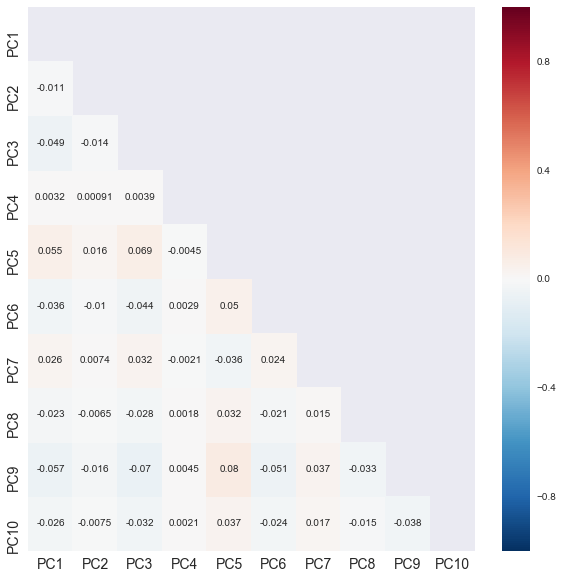

In [35]:
#Correlation matrix/heatmap

df4_corr = df4.corr()
fix, ax = plt.subplots(figsize=(10,10))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df4_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(df4_corr, mask=mask, ax=ax, annot=True)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
plt.show()